 # CS551 Final Exam: Generative Adversarial Neural Networks



 **Authors:** 
### Final Exam

Fabio Cozzuto	Student ID: 002214965

Johan Mogollon	Student ID: 002359844

 **Contributions:**

 - **Fabio Cozzuto:** All code, experiments, and analysis

 - **Johan Mogollon:** All code, experiments, and analysis


*** ABSTRACT ***


In this notebook we analyze the results of the final exam, in which we conducted an investigation of generative adversarial networks (GANs) and their different configurations. two architectures VANILLA_GAN and CYCLEGAN were used, both were trained with a dataset of “grumpy cats”, the idea is to compare the performance under two augmentations: basic and deluxe. We analyzed the loss curves of the networks, both for the generator and the discriminator, by visual inspection of the generated image at different iterations, in the same way, we evaluated how the various configurations influenced the learning process. The results lead us to interesting conclusions, providing knowledge, ideas and learning about strategies for training GANs for image transformation tasks.


# PART 1: Deep Convolutional GAN

 ## Environment Setup & Imports

In [ ]:
# Ensure Jupyter can import our GAN modules
import os, sys
sys.path.insert(0, os.path.abspath('.'))
sys.path.append('.') 

# --- Standard Libraries ---
import warnings
warnings.filterwarnings("ignore")

# --- Data Handling ---
import numpy as np
from PIL import Image
import math
np.math = math

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

# --- Local Modules ---
from data_loader import get_data_loader, CustomDataSet
from models import DCGenerator, DCDiscriminator, CycleGenerator, conv, deconv, ResnetBlock
from utils import to_var, to_data, create_dir

# --- Visualization ---
import matplotlib.pyplot as plt
import imageio # For saving images
import matplotlib.image as mpimg

# --- Argument Parsing ---
import argparse

# --- Other ---
import glob
 
# Set random seed
SEED = 11
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)
 
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Implement Data Augmentation [10 points]

We implemented the augmentations in the following code:

![alt text](images\augmentations.png)

## Implement the Discriminator of the DCGAN [10 points]

 ### 1. Padding Calculation for DCGAN Discriminator

 **Question:** With kernel size \(K=4\) and stride \(S=2\), what padding \(P\) halves the spatial dimensions?



 **Answer:** We want each layer to reduce the spatial dimensions by a factor of 2, without clipping important features. That means that we want to control the padding. So, we have the convolution output formula:

```math
O = \left \lfloor \frac{I + 2P - K}{S} \right \rfloor + 1
```
Where:
- \( I \) = input size
- \( O \) = output size
- \( K = 4 \) (kernel size)
- \( S = 2 \) (stride)
- \( P \) = padding

We want to obtain this:
```math
\text output\_size = \frac{input\_size}{2}
```
So we solve as follows: 

```math
\left\lfloor \frac{I + 2P - 4}{2} \right\rfloor + 1 = \frac{I}{2}
\Rightarrow 2P = 2 \Rightarrow P = 1
```


In [ ]:
# We can do the same calculations with the following code:

input_size = 64  # Example input size, this will vary per layer
kernel_size = 4
stride = 2
padding = 1
output_size = (input_size - kernel_size + 2 * padding) / stride + 1


print(f"Given kernel_size={kernel_size}, stride={stride}, the required padding is: {padding}")
print(f"Example: Input size = {input_size}, Output size = {output_size}")

Given kernel_size=4, stride=2, the required padding is: 1
Example: Input size = 64, Output size = 32.0


### 2. DCDiscriminator class in the models.py file

We completed the code for DCDsicriminator as you can see in the following image: 

![alt text](images\DCDiscriminator.png)

## Implement the Generator of the DCGAN [10 points]

### 1. DCGenerator class in the models.py file

![alt text](images\DCGenerator.png)

 ## Experiments


### 1. Implement the DCGAN Training Loop [10 points]

Discriminator

![alt text](images\DCGANDisc.png)

Generator

For this part we filled the code and carefully add the logger to work with TensorBoard

![alt text](images\DCGANGen.png)

### 2. Train the DCGAN [10 points]

The following code traiin the DCGAN, so this is the first execution we can do to understand the model and to see if there is some kind of error.

In [17]:
!python vanilla_gan.py --num_epochs=100

Namespace(image_size=64, conv_dim=32, noise_size=100, num_epochs=100, batch_size=16, num_workers=0, lr=0.0003, beta1=0.5, beta2=0.999, data='cat/grumpifyBprocessed', data_aug='deluxe', ext='*.png', checkpoint_dir='./checkpoints_vanilla', sample_dir='output/./vanilla\\grumpifyBprocessed_deluxe', log_step=10, sample_every=200, checkpoint_every=400)
data/cat/grumpifyBprocessed\*.png
204
                    G                  
---------------------------------------
DCGenerator(
  (deconv1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=

2025-04-18 12:25:45.926669: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 12:25:46.733076: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Basic Execution

In [20]:
!python vanilla_gan.py --data_aug=basic  --num_epochs=100

Namespace(image_size=64, conv_dim=32, noise_size=100, num_epochs=100, batch_size=16, num_workers=0, lr=0.0003, beta1=0.5, beta2=0.999, data='cat/grumpifyBprocessed', data_aug='basic', ext='*.png', checkpoint_dir='./checkpoints_vanilla', sample_dir='output/./vanilla\\grumpifyBprocessed_basic', log_step=10, sample_every=200, checkpoint_every=400)
data/cat/grumpifyBprocessed\*.png
204
                    G                  
---------------------------------------
DCGenerator(
  (deconv1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1

2025-04-18 12:33:59.464338: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 12:34:00.257890: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


##### Basic Loss Curves

On the Generator losses we can see an increase trend over the training steps. This indicates that the discriminator is getting better at separating false images from real ones, making it more difficult for the generator to "fool" it. This increase in loss may suggest that the generator requires additional effort to achieve good images, and that the discriminator is indeed getting better, outperforming the generator. However, it may also indicate that the generator is not performing as well as the training progresses.

The discriminator losses show a decreasing trend in both false images and real images. This indicates that, as training progresses, the discriminator fails to differentiate between false and real images. Now, it is possible to expect that D/false_loss is reduced as the generator gets closer to producing better images, in the same way that a reduction in D/real_loss can be seen. Both reductions would be indications that the generator is managing to “fool” the discriminator, however, it could also indicate that there is a learning problem and that therefore the discriminator is losing the ability to effectively differentiate between the two groups of images.

![alt text](images\BasicCurves.png)

![alt text](images\GLossBasic.png)

#### Deluxe Execution

In [21]:
!python vanilla_gan.py --data_aug=deluxe  --num_epochs=100

Namespace(image_size=64, conv_dim=32, noise_size=100, num_epochs=100, batch_size=16, num_workers=0, lr=0.0003, beta1=0.5, beta2=0.999, data='cat/grumpifyBprocessed', data_aug='deluxe', ext='*.png', checkpoint_dir='./checkpoints_vanilla', sample_dir='output/./vanilla\\grumpifyBprocessed_deluxe', log_step=10, sample_every=200, checkpoint_every=400)
data/cat/grumpifyBprocessed\*.png
204
                    G                  
---------------------------------------
DCGenerator(
  (deconv1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=

2025-04-18 12:34:46.358713: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 12:34:47.145111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


##### Deluxe Loss Curves

The curve D/false_loss starts high and decreases as the training progresses, showing some fluctuations during the process. Again, at the beginning, the discriminator manages to identify the generated images as false, losing accuracy as the training advances, since the generator improves its performance. Now, the fluctuations that we see could suggest moments when the discriminator adapts to the strategies of the generator to produce more realistic false images. The same way D/real_loss shows a dropping tendency from a high starting point , this suggests that the performance of the discriminator in trying to classify images decreases over the training process. The presence of the augmentations is an important component for this to happen, as the discriminator learns to identify real images even under various transformations, but the decreasing loss indicates that the generator also improves. The fluctuations could represent the Discriminator continued attempts to learn features and correctly identify images but it is not constant.

![alt text](images\DeluxeCurves.png)

![alt text](images\GLossDeluxe.png)

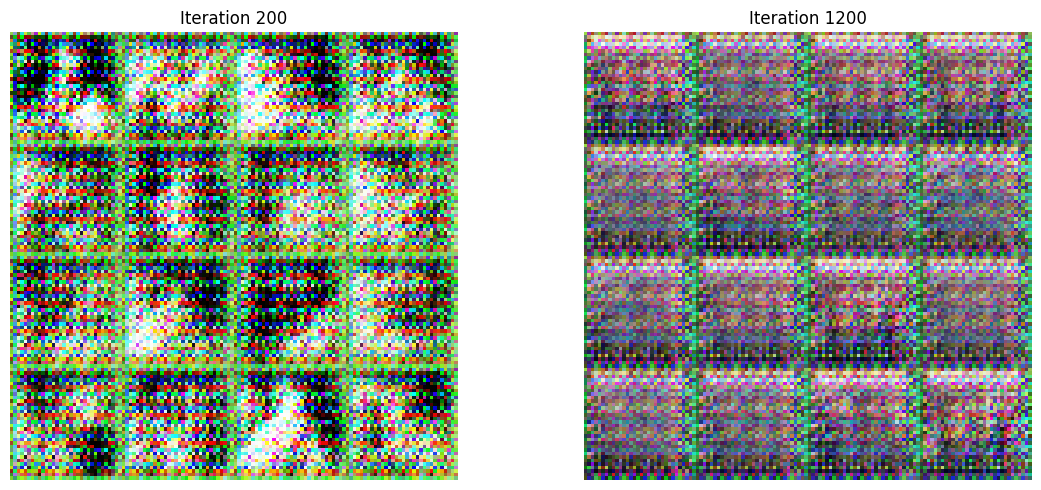

In [ ]:
# Load images from specific iterations
img_early = mpimg.imread("output/vanilla/grumpifyBprocessed_deluxe/sample-000200.png")
img_late = mpimg.imread("output/vanilla/grumpifyBprocessed_deluxe/sample-001200.png")

# Plot the images for comparison
plt.figure(figsize=(12, 5))

# Plot early stage
plt.subplot(1, 2, 1)
plt.imshow(img_early)
plt.title("Iteration 200")
plt.axis('off')

# Plot late stage
plt.subplot(1, 2, 2)
plt.imshow(img_late)
plt.title("Iteration 1200")
plt.axis('off')

plt.tight_layout()
plt.show()

In this comparison of images that Vanilla GAN generated, we can see that at the beginning, around step 200, the images are just messy noise and do not look like anything specific, not even a cat. This is normal because the network that creates the images is just starting to learn and being as basic as Vanilla_Gan is, it may not be as fast in generating good results from the beginning. However, if we look at step 1200, the images improve a bit. However, they are still blurry and although you can see some shapes and colors that maybe look a bit like cats they are not of the best quality. It is as if the network is slowly realizing what a grumpy cat looks like, but it is still not very clear or real, it is clear at this stage that the network requires many more steps to learn how to create cat images.

# PART 2: CycleGAN

## Generator [20 points]

![alt text](images\CycleGANModel.png)

## CycleGAN Training Loop [20 points]

### Discriminator

![alt text](images\CycleGANDisc.png)

### Generator Y--X-->Y CYCLE

We are going to us 𝐿1 loss, as suggested in the original paper.

![alt text](images\CycleGANGen.png)

### Generator X--Y-->X CYCLE  

![alt text](images\CycleGANGen2.png)

## CycleGAN Experiments [15 points]

#### Basic Execution

In [28]:
!python cycle_gan.py

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 64                                     
                                   disc: dc                                     
                                    gen: cycle                                  
                             g_conv_dim: 32                                     
                             d_conv_dim: 32                                     
                                   norm: instance                               
                              init_type: naive                                  
                            train_iters: 1000                                   
                             batch_size: 16                                     
                                     lr: 0.0003                                 
                            

2025-04-18 18:28:31.759220: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 18:28:32.579851: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Cycle Consistency Loss

In [29]:
!python cycle_gan.py --use_cycle_consistency_loss

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 64                                     
                                   disc: dc                                     
                                    gen: cycle                                  
                             g_conv_dim: 32                                     
                             d_conv_dim: 32                                     
                                   norm: instance                               
             use_cycle_consistency_loss: 1                                      
                              init_type: naive                                  
                            train_iters: 1000                                   
                             batch_size: 16                                     
                            

2025-04-18 18:30:31.430723: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 18:30:32.267991: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Images

![alt text](images\ImagesComparition1000.png)

Looking at the images, we can see that the ones from step 400 may be somewhat similar to the ones from step 700, although they change and look somewhat better. This is probably because when the training has just started the generator has not learned very well how to change the first type of image to look like the second type. Now, in this case, both images may not be very well created and we could at a glance identify which are fake and which are real, since if we look at step 700, even though the network tries to get better at making the images look like the other type, it may not be enough to have better textures, match colors and look more real. So we may still see some problems or things that don't look quite right because the model is still learning and trying to improve in the next steps. Something that could be improved if we revisit images in later steps in the training. 

#### Execution 10000 Iteractions

In [31]:
!python cycle_gan.py --train_iters=10000 --sample_dir=cycle_gan_10000

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 64                                     
                                   disc: dc                                     
                                    gen: cycle                                  
                             g_conv_dim: 32                                     
                             d_conv_dim: 32                                     
                                   norm: instance                               
                              init_type: naive                                  
                            train_iters: 10000                                  
                             batch_size: 16                                     
                                     lr: 0.0003                                 
                            

2025-04-18 19:12:36.649817: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 19:12:37.605297: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
!python cycle_gan.py --train_iters=10000 --sample_dir=cycle_gan_10000 --use_cycle_consistency_loss

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 64                                     
                                   disc: dc                                     
                                    gen: cycle                                  
                             g_conv_dim: 32                                     
                             d_conv_dim: 32                                     
                                   norm: instance                               
             use_cycle_consistency_loss: 1                                      
                              init_type: naive                                  
                            train_iters: 10000                                  
                             batch_size: 16                                     
                            

#### Results TensorBoard

![alt text](Images/GanComparition10000.png)

![alt text](Images/GanComparition10000_2.png)

#### Can you account for these differences?

We can see that when we use cycle consistency, the the loss curves appear more stable, as their slopes are generally gradual, without any major peaks. This could happen because the consistency loss acts as a rule that tells the networks not only to create fake images that "fool" the other network, but also to make sure that if you change an image and then change it back again, the it looks like the original image you started from. This rule helps the training to be more stable and helps the networks learn in a more organized way, rather than in a disorganized way, trying to "fool" each other all the time. The generator seems to learn better when we this rule applies.


#### Provide explanations as to why there might or might not be a noticeable difference between the two sets of results.


Analyzing the images, one possible explanation as to why we do not see a big difference in the images in the end, is because the two types of “grumpy cats” we are using are not that different in style. If the change we want to make is not too significant, the network can probably learn to do it right, even without the cycle consistency rule. Also, the rule has a weight (lambda), that if we do not adjust correctly, it may not help the network in its learning process. Additionally, in this case we use 𝐿1 loss, as the original paper suggested. Perhaps, if we trained longer or used larger networks, or if the difference between cat styles was more noticeable, we would see a significant improvement in the images produced, when we use the cycle coherence rule. This indicates that the rule helps the learning process to be more stable. However, for the images to look much better, we could apply further augmentations or train for longer.